# **Mobile Money Fraud Detection with Ensemble Machine Learning**
* **Author:** *Stephen Adarkwah*
* **Author Date:** *20240801*
* **Version:** *1.0*
  
### Context
Mobile money fraud detection using machine learning is critical in safeguarding financial ecosystems. It involves applying advanced algorithms and data analysis techniques to identify suspicious activities and prevent real-time fraudulent transactions. An effective fraud detection system should be able to detect fraudulent transactions with high accuracy and efficiency. While avoiding bad actors from executing fraudulent transactions is necessary, ensuring genuine users can access the payment system is also critical. However, many false positives may lead to a poor customer experience, potentially driving customers to take their business elsewhere and highlighting the need for accurate fraud detection.

### Other Challenges 
 A significant challenge in building fraud detection models in research is the availability of transactional datasets due to confidentiality and data governance policies around financial data. Another major challenge in applying Machine Learning to fraud detection is the presence of highly imbalanced data sets. In many available datasets, most transactions are genuine, with a tiny percentage of fraudulent transactions. Designing an accurate and efficient fraud detection system that is low on false positives but detects fraudulent activity effectively is a significant challenge for researchers. 
 
### About Dataset 
The lack of legitimate datasets in mobile money transactions to perform fraud detection research has always been a big problem. This will leave researchers with the burden of harnessing the datasets before conducting the research. Paysim is a financial simulator that simulates mobile money transactions based on an original dataset.

PaySim is based on a sample of genuine mobile money transactions from an African country provided by a multinational company with services in over 14 countries. This synthetic approach offers a valuable resource for advancing fraud detection research. You can clone PaySim source repository at https://github.com/EdgarLopezPhD/PaySim/tree/master which is a java based application.

*These fields form the basis of the synthetic dataset, providing a comprehensive view of transaction activities while offering opportunities to study and test fraud detection methods.*


### Research Goals
1. Are there limitations in using ensemble learning to combat modern-day Mobile Money fraud?
2. Can these limitations be fixed or improved?
3. Is ensemble learning an effective combatant against mobile money fraud in contrast to traditional solutions like data mining, anonymous tip lines (including online or website) and financial auditing?



#### Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



#### Get simulated data

In [3]:
# Loading datasets
df = pd.read_csv('./outputs/paysim.csv')

# fix column names to camel case
dataset = df.rename(columns={'oldbalanceOrg':'oldBalanceOrg', 'newbalanceOrig':'newBalanceOrig',
                             'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
dataset.head()

,step,type,amount,nameOrig,oldBalanceOrg,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# check schema
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrg   float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB



The dataset contains the following attributes:

* **step:** This is a unit of time representing one hour in the real world. The total number of steps is 744, corresponding to a 30-day simulation.

* **type:** The type of transaction performed. The possible types are *CASH-IN*, *CASH-OUT*, *DEBIT*, *PAYMENT*, and *TRANSFER*.

#### About type of transactions
* CASH-IN: Refers to depositing cash into an account (adding funds).

* CASH-OUT: Refers to withdrawing cash from an account (removing funds).

* DEBIT: It refer to a decrease in the balance of a financial account due to a withdrawal or an expense.

* PAYMENT: Refers to the transfer of money from one party (payer) to another (payee) in exchange for goods, services, or as settlement of a debt.

* TRANSFER: Refers to moving money from one account to another, often between accounts held by the same person or entity.


* **amount:** The transaction amount in your preferred local currency (£ in my case).

* **nameOrig:** The customer who initiated the transaction.

* **oldBalanceOrig:** The initial balance of the customer before the transaction.

* **newBalanceOrig:** The new balance of the customer after the transaction.

* **nameDest:** The recipient of the transaction.

* **oldBalanceDest:** The initial balance of the recipient before the transaction. There is no information for customers whose names start with "M" (merchants).

* **newBalanceDest:** The new balance of the recipient after the transaction. As with "oldbalanceDest," there is no information for customers whose names start with "M." (merchants)

* **isFraud:** Indicates whether a transaction is fraudulent.

* **isFlaggedFraud:** Flags transactions that exceed a certain threshold. In this dataset, transfers over 200,000 in a single transaction are flagged as potentially fraudulent.




I get the summarized overview of the dataset to observe the distribution/dispersion in data points.

In [5]:
# get statistics
dataset.describe()

,step,amount,oldBalanceOrg,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


The dataset has 6362620 transactions,the mean fraud is 0.00129 which means there very few fraud cases recorded ie. 13 real fraud cases every 10,000 transactions. However the number of successfully detected fraudulent transaction by the system is very low at 0.025 successful detection per 10,000 transactions. This goes to proof why we need excellent/advanced mechanisms to help detect fraud more effectively.

### Data Exploration

From experience in working in the banking for 6 years, most fraud case I have witnessed have correlations with transaction types, accounts, and amount.

Let’s see the distribution for each attribute. I will use plot visualization to get insight the dataset.

#### Fraud

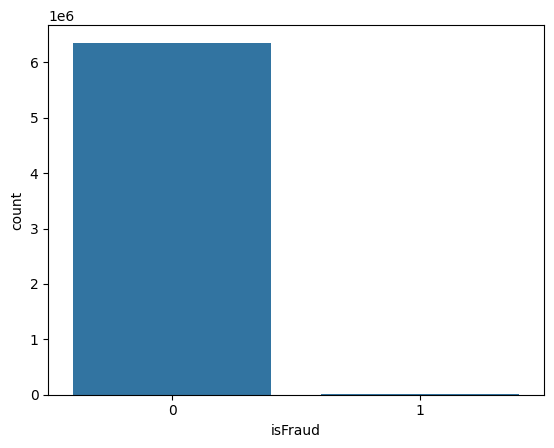

In [6]:
# Fraud

sns.countplot(x = 'isFraud',  data=dataset)
plt.show()

In [7]:
# number of actual frauds in the dataset
dataset.groupby('isFraud')['isFraud'].count()

isFraud
0    6354407
1       8213
Name: isFraud, dtype: int64

From the diagram above its almost impossible to see the number of fraud transaction due to its small value. But as we can see 8213 compared to 6354407 is very small. It's possible that frauds infrequently happens in this dataset and hence the values we are seeing is accurate.

#### Flagged Fraud

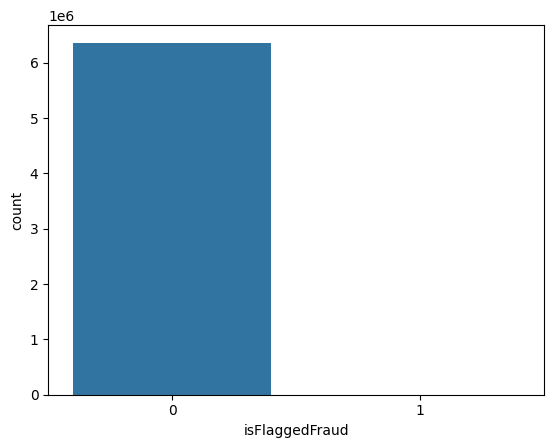

In [12]:
# successfully flagged fraud
sns.countplot(x = 'isFlaggedFraud',  data=dataset)
plt.show()

In [13]:
# number of successfully flagged frauds in the dataset
dataset.groupby('isFlaggedFraud')['isFlaggedFraud'].count()

isFlaggedFraud
0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

16 successfully detected frauds out of 8213 is a very poor performance for a fraud detection. That is 0.19% of actual fraud that occurred. This is a good case to employ advance or more competent fraud detection mechanisms for effective and efficient fraud detection.

#### Transaction Types

<Axes: xlabel='type', ylabel='count'>

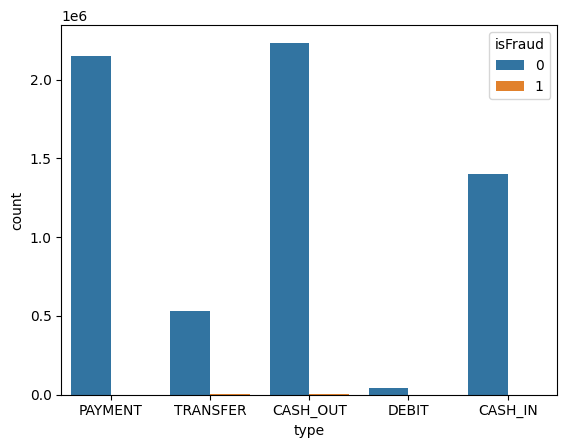

In [8]:
# Transaction Types
sns.countplot(x = 'type', hue='isFraud',  data=dataset)

In [16]:
# Get the number of fraud cases in each transaction type
dataset.groupby('type').agg(transaction_count = ('type', 'count'),
                                   isFraud =('isFraud','sum'),).reset_index()


,type,transaction_count,isFraud
0,CASH_IN,1399284,0
1,CASH_OUT,2237500,4116
2,DEBIT,41432,0
3,PAYMENT,2151495,0
4,TRANSFER,532909,4097


We can see that the **TRANSFER** and **CASH_OUT** types are mainly used to commit these fraud transactions. These transaction operations make sense because they involve an end-user physically withdrawing or moving money into an account of choice.

#### Transaction Type VS Fraud VS Flagged Fraud

In [18]:
# Get the number of fraud cases and detected cases in each transaction type
sta_df = dataset.groupby('type').agg(isFraud = ('isFraud', 'sum'),
                                   isFlaggedFraud =('isFlaggedFraud','sum'),).reset_index()


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'CASH_IN'),
  Text(1, 0, 'CASH_OUT'),
  Text(2, 0, 'DEBIT'),
  Text(3, 0, 'PAYMENT'),
  Text(4, 0, 'TRANSFER')])

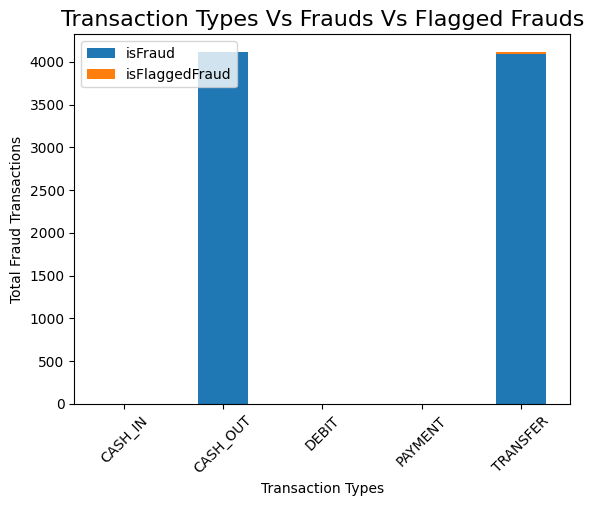

In [19]:
#create stacked bar chart for transaction_types Vs actual Fraud Vs successfully detected Fraud
sta_df.set_index('type').plot(kind='bar', stacked=True)

#add overall title
plt.title('Transaction Types Vs Frauds Vs Flagged Frauds', fontsize=16)

#add axis titles
plt.xlabel('Transaction Types')
plt.ylabel('Total Fraud Transactions')

#rotate x-axis labels
plt.xticks(rotation=45)

In [15]:
# Get the all fraud cases in each transaction type
sta_df

,type,isFraud,isFlaggedFraud
0,CASH_IN,0,0
1,CASH_OUT,4116,0
2,DEBIT,0,0
3,PAYMENT,0,0
4,TRANSFER,4097,16


From the chart above you can see that successfully detected fraud is a small fraction of the total fraud cases and occurred for **TRANSFER** type transactions only. This makes sense because if there are policies/rules like KYC system check it is harder to detect **CASH_OUT** because it involves a lot human element which is uncontrolled especially when it has to do with mobile money. Social engineering are means fraudsters use to get confidential information from customer, end with that can initiate withdrawals easily.
**CASH_OUT** fraud is almost impossible to also revert as well because, when the money is removed from the account it cannot be tracked, while **TRANSFER** is likely be detected because account to account transactions can be tracked and policies governing accounts flag these transactions easily.

#### Accounts

Accounts usually have correlations to fraud, fraud detection system monitor and flag certain account due to the type of amount the account sends and receives respectively or by other factors. Example **CASH_OUT** transaction type source accounts (**nameOrig**) can normally be the destination account for a previous **TRANSFER** type transaction.

In [ ]:
# Was a CASH_OUT transaction source account(nameOrig) previously used as TRANSFER transactions destination account?
